# Posterior overlap

## Bayes factor

$$
\begin{equation}
\begin{split}
\mathcal{B}_U^L &= \frac{ \int d\theta \frac{P(\theta|d_1)}{P_{pe}(\theta)} \frac{P(\theta|d_2)}{P_{pe}(\theta)} P_{astro}(\theta|H_L) }
{\int d\theta \frac{P(\theta|d_1)}{P_{pe}(\theta)} \frac{P(\theta|d_2)}{P_{pe}(\theta)} P_{astro}(\theta|H_U)} \\ \nonumber
=& \Bigg[\\
& \bigg< \\
&\;P(m_{1}, m_{2},\alpha, \delta, \iota, \chi_{eff}, d_{L,1}|T_1, d_1)\times \\
&\;P(m_{1}, m_{2},\alpha, \delta, \iota, \chi_{eff}, d_{L,2}|T_2, d_2) \times \\
&\; P_{astro}(m_{1}, m_{2}, \alpha, \delta, \iota, \chi_{eff}, d_{L,1}, d_{L,2}, \Delta T_2|H_L) \div \\
& \bigg(P_{pe}(m_{1}, m_{2}, , \chi_{eff}) P_{pe}(\alpha) P_{pe}(\delta) P_{pe}(\iota) P_{pe}(d_{L})\bigg)^2 \div \\
&\; P_{comb}(m_{1}, m_{2}, \alpha, \delta, \iota, \chi_{eff}, d_{L,1}, d_{L,2}|d_1, d_2) \\
&\bigg>_{ m_{1}, m_{2}, d_{L,1}, \iota, \chi_{eff}, d_{L,2}\in P_{comb}(.|d_1, d_2)} \\
& \Bigg] \div \Bigg[\\
& \bigg<\\
&\; P_{astro}(m_{1,1}, m_{2,1}, \alpha_1, \delta_1, \iota_1, \chi_{eff,1}, d_{L,1}|H_U)\times \\
&\; P_{astro}(m_{1,2}, m_{2,2}, d_{L,2}, \iota_2, \chi_{eff,2}, d_{L,2}, \Delta T_2|H_U) \div \\
& \bigg(P_{pe}(m_{1}, m_{2}, \chi_{eff}) P_{pe}(\alpha) P_{pe}(\delta) P_{pe}(\iota) P_{pe}(d_{L})\bigg)^2 \\
&\bigg>_{ m_{1,1}, m_{2,1},\alpha_1, \delta_1, \iota_1, \chi_{eff,1}, d_{L,1}\in P(.|T_1,d_1),}\\&_{\; m_{1,2}, m_{2,2},\alpha_2, \delta_2, \iota_2, \chi_{eff,2}, d_{L,2}\in P(.|T_2,d_2)} \\
& \Bigg]
\end{split}
\end{equation}
$$

**Note**: I didn't seperate out the integrand in the denominator as 
$$\int d\theta \frac{P(\theta|d_1)}{P_{pe}(\theta)} \frac{P(\theta|d_2)}{P_{pe}(\theta)} P_{astro}(\theta|H_U)=
\int d\theta \frac{P(\theta|d_1)}{P_{pe}(\theta)} P_{astro}(\theta|H_U) 
\int d\theta \frac{P(\theta|d_2)}{P_{pe}(\theta)} P_{astro}(\theta|H_U)$$
This is because I want to use the time delay information in the denominator as well. For unlensed events, time delay follows a possion distribution where its peak depends the on prior range (1 year for this example).

Priors:

* $P_{comb}(m_{1}, m_{2}, \alpha, \delta, \iota, \chi_{eff}, d_{L,1}, d_{L,2}|d_1, d_2)$ is the obtained by combining the posterior distribution of the parameters for the given two dataset.

* $P(m_{1,1}, m_{2,1},\alpha_1, \delta_1, \iota_1, \chi_{eff,1}, d_{L,1}|T_1, d_1)$ and $P(m_{1,2}, m_{2,2},\alpha_2, \delta_2, \iota_2, \chi_{eff,2}, d_{L,2}|T_2, d_2)$ are the posterior distribution of the parameters for the given two dataset respectively.

* Multidimensional KDE is used to sample the new parameters for monte carlo integration.

PDFs:

* $P(m_{1}, m_{2},\alpha, \delta, \iota, \chi_{eff}, d_{L,1}|T_1, d_1)$, $P(m_{1}, m_{2},\alpha, \delta, \iota, \chi_{eff}, d_{L,2}|T_2, d_2)$ are PDF of the parameters for the given two dataset respectively.

* $P_{astro}(m_{1}, m_{2}, \alpha, \delta, \iota, \chi_{eff}, d_{L,1}, d_{L,2}, \Delta T_2|H_L)$ is the PDF of the parameters in the lensed hypothesis.

* $P_{astro}(m_{1,1}, m_{2,1}, \alpha_1, \delta_1, \iota_1, \chi_{eff,1}, d_{L,1}|H_U)$ and $P_{astro}(m_{1,2}, m_{2,2}, d_{L,2}, \iota_2, \chi_{eff,2}, d_{L,2}, \Delta T_2|H_U)$ are the PDF of the parameters in the unlensed hypothesis.

* $P_{pe}(m_{1}, m_{2}, \chi_{eff})$, $P_{pe}(\alpha)$, $P_{pe}(\delta)$, $P_{pe}(\iota)$, $P_{pe}(d_{L})$ are the PDFs obtained from the bilby default BBH's prior distribution.

* Multidimensional KDE is used to find the probability density of the parameters.

In [24]:
import numpy as np
from pobs.utils import get_param_from_json, save_json, load_json, plot
from pobs.modelgenerator_dpgmm import ModelGenerator
from pobs.utils import plot
import matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture
import corner
import matplotlib.lines as mlines
import h5py 
import pandas as pd
import json
import pickle

## Define all scaling functions

In [2]:
import scipy.stats as stats
from scipy.stats import norm

def uniform_to_gaussian(x, mu=0, sigma=1, upper_bound=0.8, lower_bound=0):
    # Transform to U(0,1)
    U = x / abs(upper_bound - lower_bound)

    # Transform to standard normal
    Z = norm.ppf(U)

    # If you want a normal distribution with mean mu and standard deviation sigma
    X = mu + sigma * Z
    return X

def gaussian_to_uniform(X, mu=0, sigma=1, upper_bound=0.8, lower_bound=0):
    # Reverse the normal scaling to standard normal
    Z = (X - mu) / sigma

    # Transform standard normal back to U(0,1)
    U = norm.cdf(Z)

    # Scale U(0,1) back to U(0, 0.8)
    x = abs(upper_bound - lower_bound) * U
    return x

def sine_to_gaussian(X):
    uniform = (np.cos(X) + 1) / 2  # Convert to Uniform[0, 1]
    gaussian = norm.ppf(uniform)  # Apply the inverse CDF of the Gaussian distribution
    return gaussian

def gaussian_to_sine(X):
    uniform = norm.cdf(X)  # Apply the CDF of the Gaussian distribution
    sine = np.arccos(2 * uniform - 1)  # Convert to the sine of the angle
    return sine

def cosine_to_gaussian(X):
    uniform = (np.sin(X) + 1) / 2  # Convert to Uniform[0, 1]
    gaussian = norm.ppf(uniform)  # Apply the inverse CDF of the Gaussian distribution
    return gaussian

def gaussian_to_cosine(X):
    uniform = norm.cdf(X)  # Apply the CDF of the Gaussian distribution
    cosine = np.arcsin(2 * uniform - 1)  # Convert to the cosine of the angle
    return cosine

def scale_to_range(X, min_data=None, max_data=None, min_target=0+0.0001, max_target=np.pi-0.0001):
    if min_data is None:
        min_data = np.min(X)
    if max_data is None:
        max_data = np.max(X)
    X_std = (X - min_data) / (max_data - min_data)
    X_scaled = X_std * (max_target - min_target) + min_target
    return X_scaled

def unscale_to_range(X, min_data, max_data, min_target=0+0.0001, max_target=np.pi-0.0001):
    X_scaled = (X - min_target) / (max_target - min_target)
    X_unscaled = X_scaled * (max_data - min_data) + min_data
    return X_unscaled

# for saving min max values for scaling as json
def save_min_max(data_dict, filename):
    min_max = {}
    for key, value in data_dict.items():
        min_max[key] = dict(
            min_data = np.min(value), 
            max_data = np.max(value),
        )
    save_json(filename, min_max)

In [3]:
def get_model_and_scaler(model_path, scaler_path, min_max_path=None, dir='ler_data'):
    
    with open(dir+'/'+model_path, 'rb') as f:
        dpgmm = pickle.load(f)

    with open(dir+'/'+scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    if min_max_path is not None:
        min_max = load_json(dir+'/'+min_max_path)
        return dpgmm, scaler, min_max
    else:
        return dpgmm, scaler

## Astrophysical parameter distributions

## Lensed events

* $P_{astro}(m_{1}, m_{2}, \alpha, \delta, \iota, \chi_{eff}, d_{L,1}, d_{L,2}, \Delta T_2|H_L)$

In [4]:
def data_check_astro_lensed(data_dict):

    lensed_param = {}

    param_list = ['ra', 'dec', 'theta_jn', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'mass_1', 'mass_2', 'effective_luminosity_distance', 'effective_geocent_time', 'optimal_snr_net']
    for key in param_list:
        try:
            lensed_param[key] = np.array(data_dict[key])
        except:
            print(f"data_dict should have the following keys: {param_list}")
            raise ValueError(f"{key} is not present in the data_dict")

    # seperate out image 1, 2
    # this is wrt to time of arrival
    lensed_param_1 = {}
    lensed_param_2 = {}

    for key, value in lensed_param.items():
        if np.shape(np.shape(value))[0]==2:
            lensed_param_1[key] = np.array(value)[:,0]
            lensed_param_2[key] = np.array(value)[:,1]
        else:
            lensed_param_1[key] = np.array(value)
            lensed_param_2[key] = np.array(value)

    # For image 1 and 2 only
    # only keep snr > 8
    idx_snr1 = lensed_param_1['optimal_snr_net'] > 8
    idx_snr2 = lensed_param_2['optimal_snr_net'] > 8
    idx_snr = idx_snr1 & idx_snr2

    # log10 for (time/86400) and luminosity distance
    data_dict = dict(
        mass_1 = lensed_param_1['mass_1'][idx_snr],
        mass_2 = lensed_param_1['mass_2'][idx_snr],
        ra = lensed_param_1['ra'][idx_snr],
        dec = lensed_param_1['dec'][idx_snr],
        theta_jn = lensed_param_1['theta_jn'][idx_snr],
        dl_1 = lensed_param_1['effective_luminosity_distance'][idx_snr],
        dl_2 = lensed_param_2['effective_luminosity_distance'][idx_snr],
        dt_12 = (lensed_param_2['effective_geocent_time'][idx_snr] - lensed_param_1['effective_geocent_time'][idx_snr]),
    )

    return data_dict

In [26]:
# get data for detectable events
data_dict = get_param_from_json('/Users/phurailatpamhemantakumar/phd/mypackages/pobs/pobs/data/n_lensed_detectable_bbh_po_spin.json')
lensed_param = data_check_astro_lensed(data_dict)
lensed_param.keys()

dict_keys(['mass_1', 'mass_2', 'ra', 'dec', 'theta_jn', 'dl_1', 'dl_2', 'dt_12'])

In [28]:
list1 = ['mass_1', 'mass_2', 'theta_jn', 'dl_1', 'dl_2', 'dt_12']
list2 = ['ra', 'dec']

lensed_param1 = {key: lensed_param[key] for key in list1}
lensed_param2 = {key: lensed_param[key] for key in list2}

In [31]:
lensed_param1

{'mass_1': array([66.29548869, 83.51377537, 67.19394157, ..., 43.16685331,
        59.56931082, 17.05525893]),
 'mass_2': array([32.97891752, 79.77414169, 59.01243546, ..., 43.07506727,
        49.25245077, 16.24973014]),
 'theta_jn': array([2.69125255, 2.79151912, 0.49697735, ..., 0.33025092, 2.66177192,
        0.10607934]),
 'dl_1': array([5291.57557443, 6836.58420925, 5621.88202095, ..., 6262.48256797,
        6266.84606435, 1611.29273128]),
 'dl_2': array([5161.42384331, 6389.28541798, 3388.099412  , ..., 6017.22285335,
        5122.50807544, 1261.22233063]),
 'dt_12': array([ 771161.81580353,   45727.02126026,  207698.26330113, ...,
         233354.96444297, 8014119.80023408,   63281.34012818])}

In [29]:
data_dict = lensed_param1
min_max1 = {}
for key, value in data_dict.items():
    min_max1[key] = dict(
        min_data = np.min(value), 
        max_data = np.max(value),
    )

data_dict = lensed_param2
min_max2 = {}
for key, value in data_dict.items():
    min_max2[key] = dict(
        min_data = np.min(value), 
        max_data = np.max(value),
    )

In [30]:
min_max1

{'mass_1': {'min_data': 8.49334658324642, 'max_data': 154.01733564365327},
 'mass_2': {'min_data': 7.764873736052614, 'max_data': 92.3805466274578},
 'theta_jn': {'min_data': 0.0011118399881663195,
  'max_data': 3.1369650057219367},
 'dl_1': {'min_data': 154.58852693085328, 'max_data': 14147.319013364562},
 'dl_2': {'min_data': 149.94431023834036, 'max_data': 15528.887790678253},
 'dt_12': {'min_data': 3.429860830307007, 'max_data': 506272789.6327996}}

In [12]:
# # what original data looks like
# test1.plot(lensed_param1)
# test2.plot(lensed_param2)

### astro_lensed

In [32]:
# list of dict values
train_data_ = np.array([lensed_param1[key] for key in lensed_param1.keys()]).T
train_data_.shape

(40034, 6)

In [33]:
# scale data

# scale m1
train_data_[:,0] = scale_to_range(train_data_[:,0], min_max1['mass_1']['min_data'], min_max1['mass_1']['max_data'])
train_data_[:,0] = sine_to_gaussian(train_data_[:,0])

# scale m2
train_data_[:,1] = scale_to_range(train_data_[:,1], min_max1['mass_2']['min_data'], min_max1['mass_2']['max_data'])
train_data_[:,1] = sine_to_gaussian(train_data_[:,1])

# scale theta_jn
train_data_[:,2] = sine_to_gaussian(train_data_[:,2])

# scale dl1
train_data_[:,3] = np.log10(train_data_[:,3])

# scale dl2
train_data_[:,4] = np.log10(train_data_[:,4])

# scale dt_12
train_data_[:,5] = np.log10(train_data_[:,5]/86400)

In [37]:
# create a dictionary for the scaled data
train_data_dict = dict(
    mass_1 = train_data_[:,0],
    mass_2 = train_data_[:,1],
    theta_jn = train_data_[:,2],
    log10_dl_1 = train_data_[:,3],
    log10_dl_2 = train_data_[:,4],
    log10_dt_12_days = train_data_[:,5],
)
print(train_data_dict)

{'mass_1': array([ 0.40885113, -0.06111577,  0.38383655, ...,  1.10918579,
        0.59958842,  2.38563258]), 'mass_2': array([ 0.82894937, -1.60916159, -0.4204339 , ...,  0.32772188,
        0.03816989,  1.96654395]), 'theta_jn': array([-1.64630547, -1.87602022,  1.55070533, ...,  1.92652385,
       -1.58519379,  2.76909995]), 'log10_dl_1': array([3.723585  , 3.83483917, 3.74988173, ..., 3.79674653, 3.79704903,
       3.20717445]), 'log10_dl_2': array([3.71276952, 3.80545229, 3.52995614, ..., 3.7793961 , 3.70948265,
       3.10079165]), 'log10_dt_12_days': array([ 0.95063177, -0.27634083,  0.38091912, ...,  0.4315033 ,
        1.96734209, -0.13523807])}


In [38]:
from sklearn.preprocessing import StandardScaler
# Choose a scaler:
scaler = StandardScaler()  # or MinMaxScaler(), RobustScaler()

# Scale the data
scaler.fit(train_data_)
scaled_data = scaler.transform(train_data_)

In [40]:
train_data_

array([[ 0.40885113,  0.82894937, -1.64630547,  3.723585  ,  3.71276952,
         0.95063177],
       [-0.06111577, -1.60916159, -1.87602022,  3.83483917,  3.80545229,
        -0.27634083],
       [ 0.38383655, -0.4204339 ,  1.55070533,  3.74988173,  3.52995614,
         0.38091912],
       ...,
       [ 1.10918579,  0.32772188,  1.92652385,  3.79674653,  3.7793961 ,
         0.4315033 ],
       [ 0.59958842,  0.03816989, -1.58519379,  3.79704903,  3.70948265,
         1.96734209],
       [ 2.38563258,  1.96654395,  2.76909995,  3.20717445,  3.10079165,
        -0.13523807]])

In [39]:
# scaled_data as value
data_dict = dict(
    mass_1 = scaled_data[:,0],
    mass_2 = scaled_data[:,1],
    theta_jn = scaled_data[:,2],
    log10_dl_1 = scaled_data[:,3],
    log10_dl_2 = scaled_data[:,4],
    log10_dt_12_days = scaled_data[:,5],
)
data_dict

{'mass_1': array([-0.25358099, -0.76477342, -0.28078985, ...,  0.50818708,
        -0.04611221,  1.89660388]),
 'mass_2': array([ 0.56138857, -1.53836914, -0.51460928, ...,  0.12971984,
        -0.11964906,  1.54111141]),
 'theta_jn': array([-1.06144538, -1.20915124,  0.99422241, ...,  1.23587253,
        -1.02215076,  1.77764628]),
 'log10_dl_1': array([ 0.580454  ,  1.076712  ,  0.69775262, ...,  0.90679677,
         0.90814609, -1.72303613]),
 'log10_dl_2': array([ 0.77496396,  1.13697065,  0.06091895, ...,  1.03519859,
         0.76212587, -1.61534111]),
 'log10_dt_12_days': array([-0.22656306, -1.39829257, -0.77062502, ..., -0.72231834,
         0.74437099, -1.26354281])}

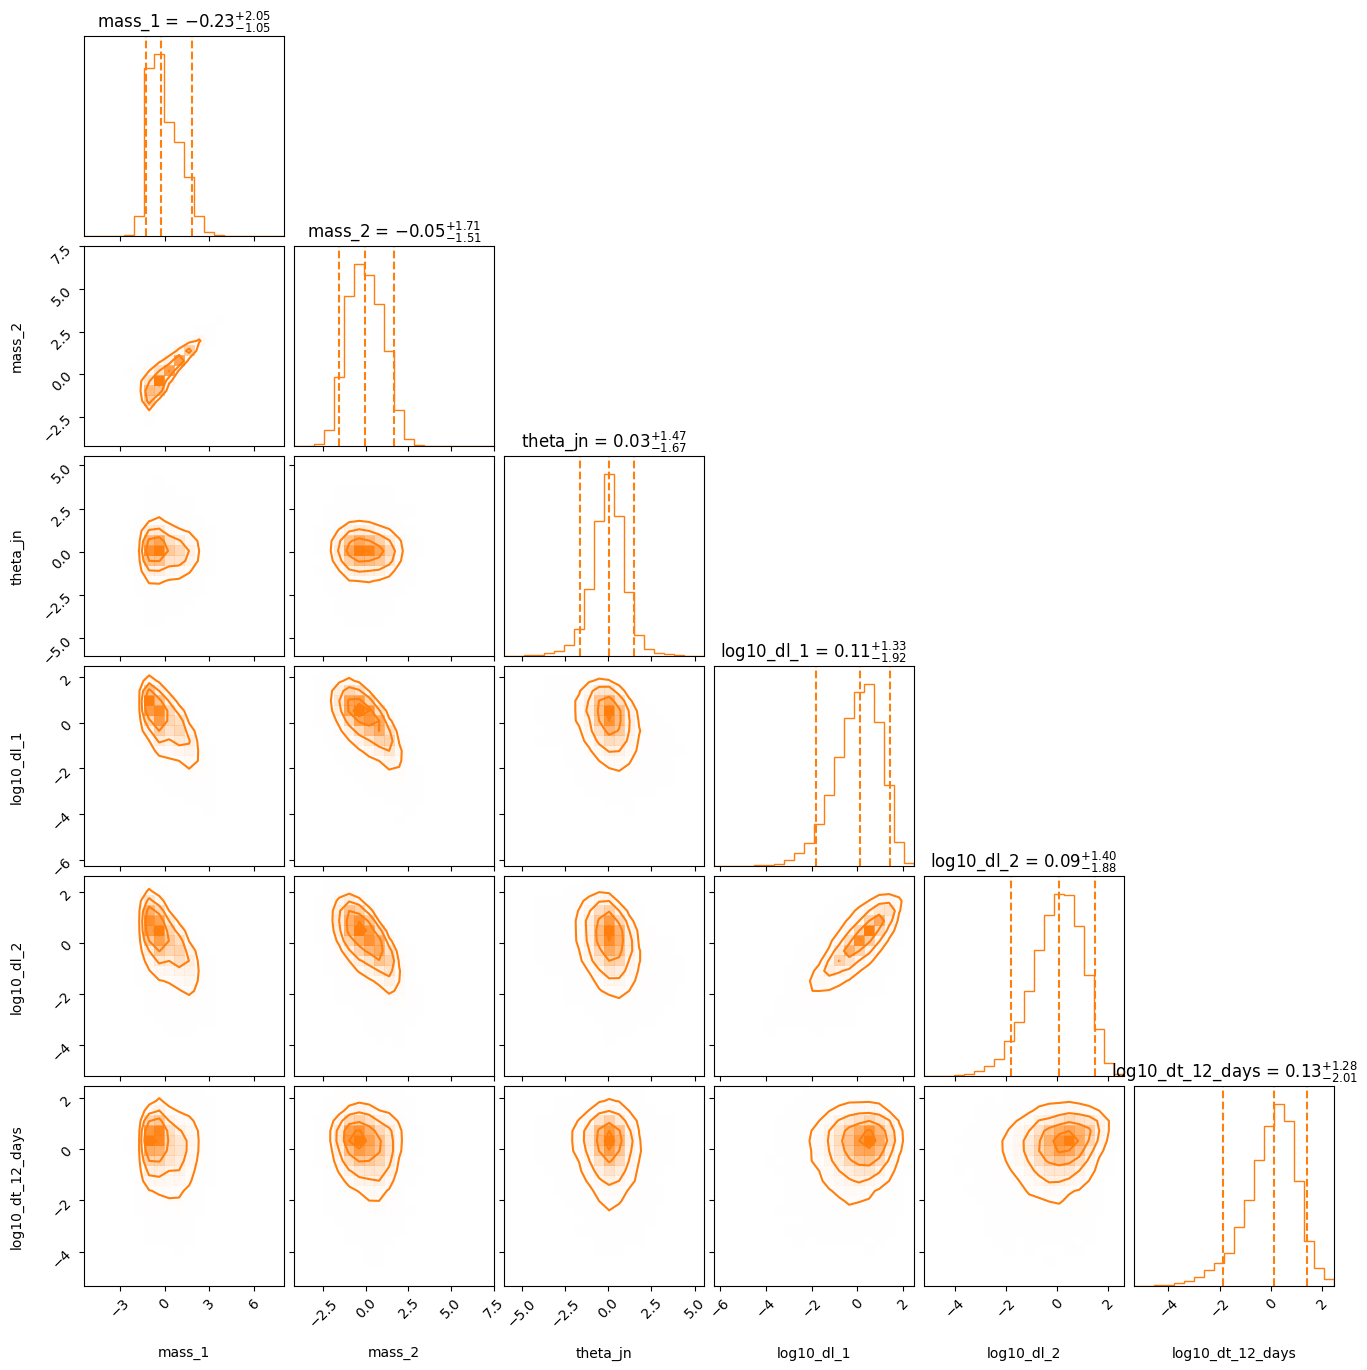

In [ ]:
plot(data_dict)

In [ ]:
test.plot(scaled_data)

In [ ]:
# Fit the model
# Set up the Dirichlet Process Gaussian Mixture Model
dpgmm = BayesianGaussianMixture(
    n_components=10,  # Large enough to capture complexity
    covariance_type='full',  # Each component can have its own covariance
    weight_concentration_prior=1e-1,  # Smaller values encourage more clusters
    max_iter=500,  # Increase for more convergence stability
    random_state=42
    )
# time for training, n_components=20, weight_concentration_prior=1e-2, max_iter=1000: 3m 14.6s
# time for training, n_components=10, weight_concentration_prior=1e-1, max_iter=500: 3m 14.6s
dpgmm.fit(scaled_data)

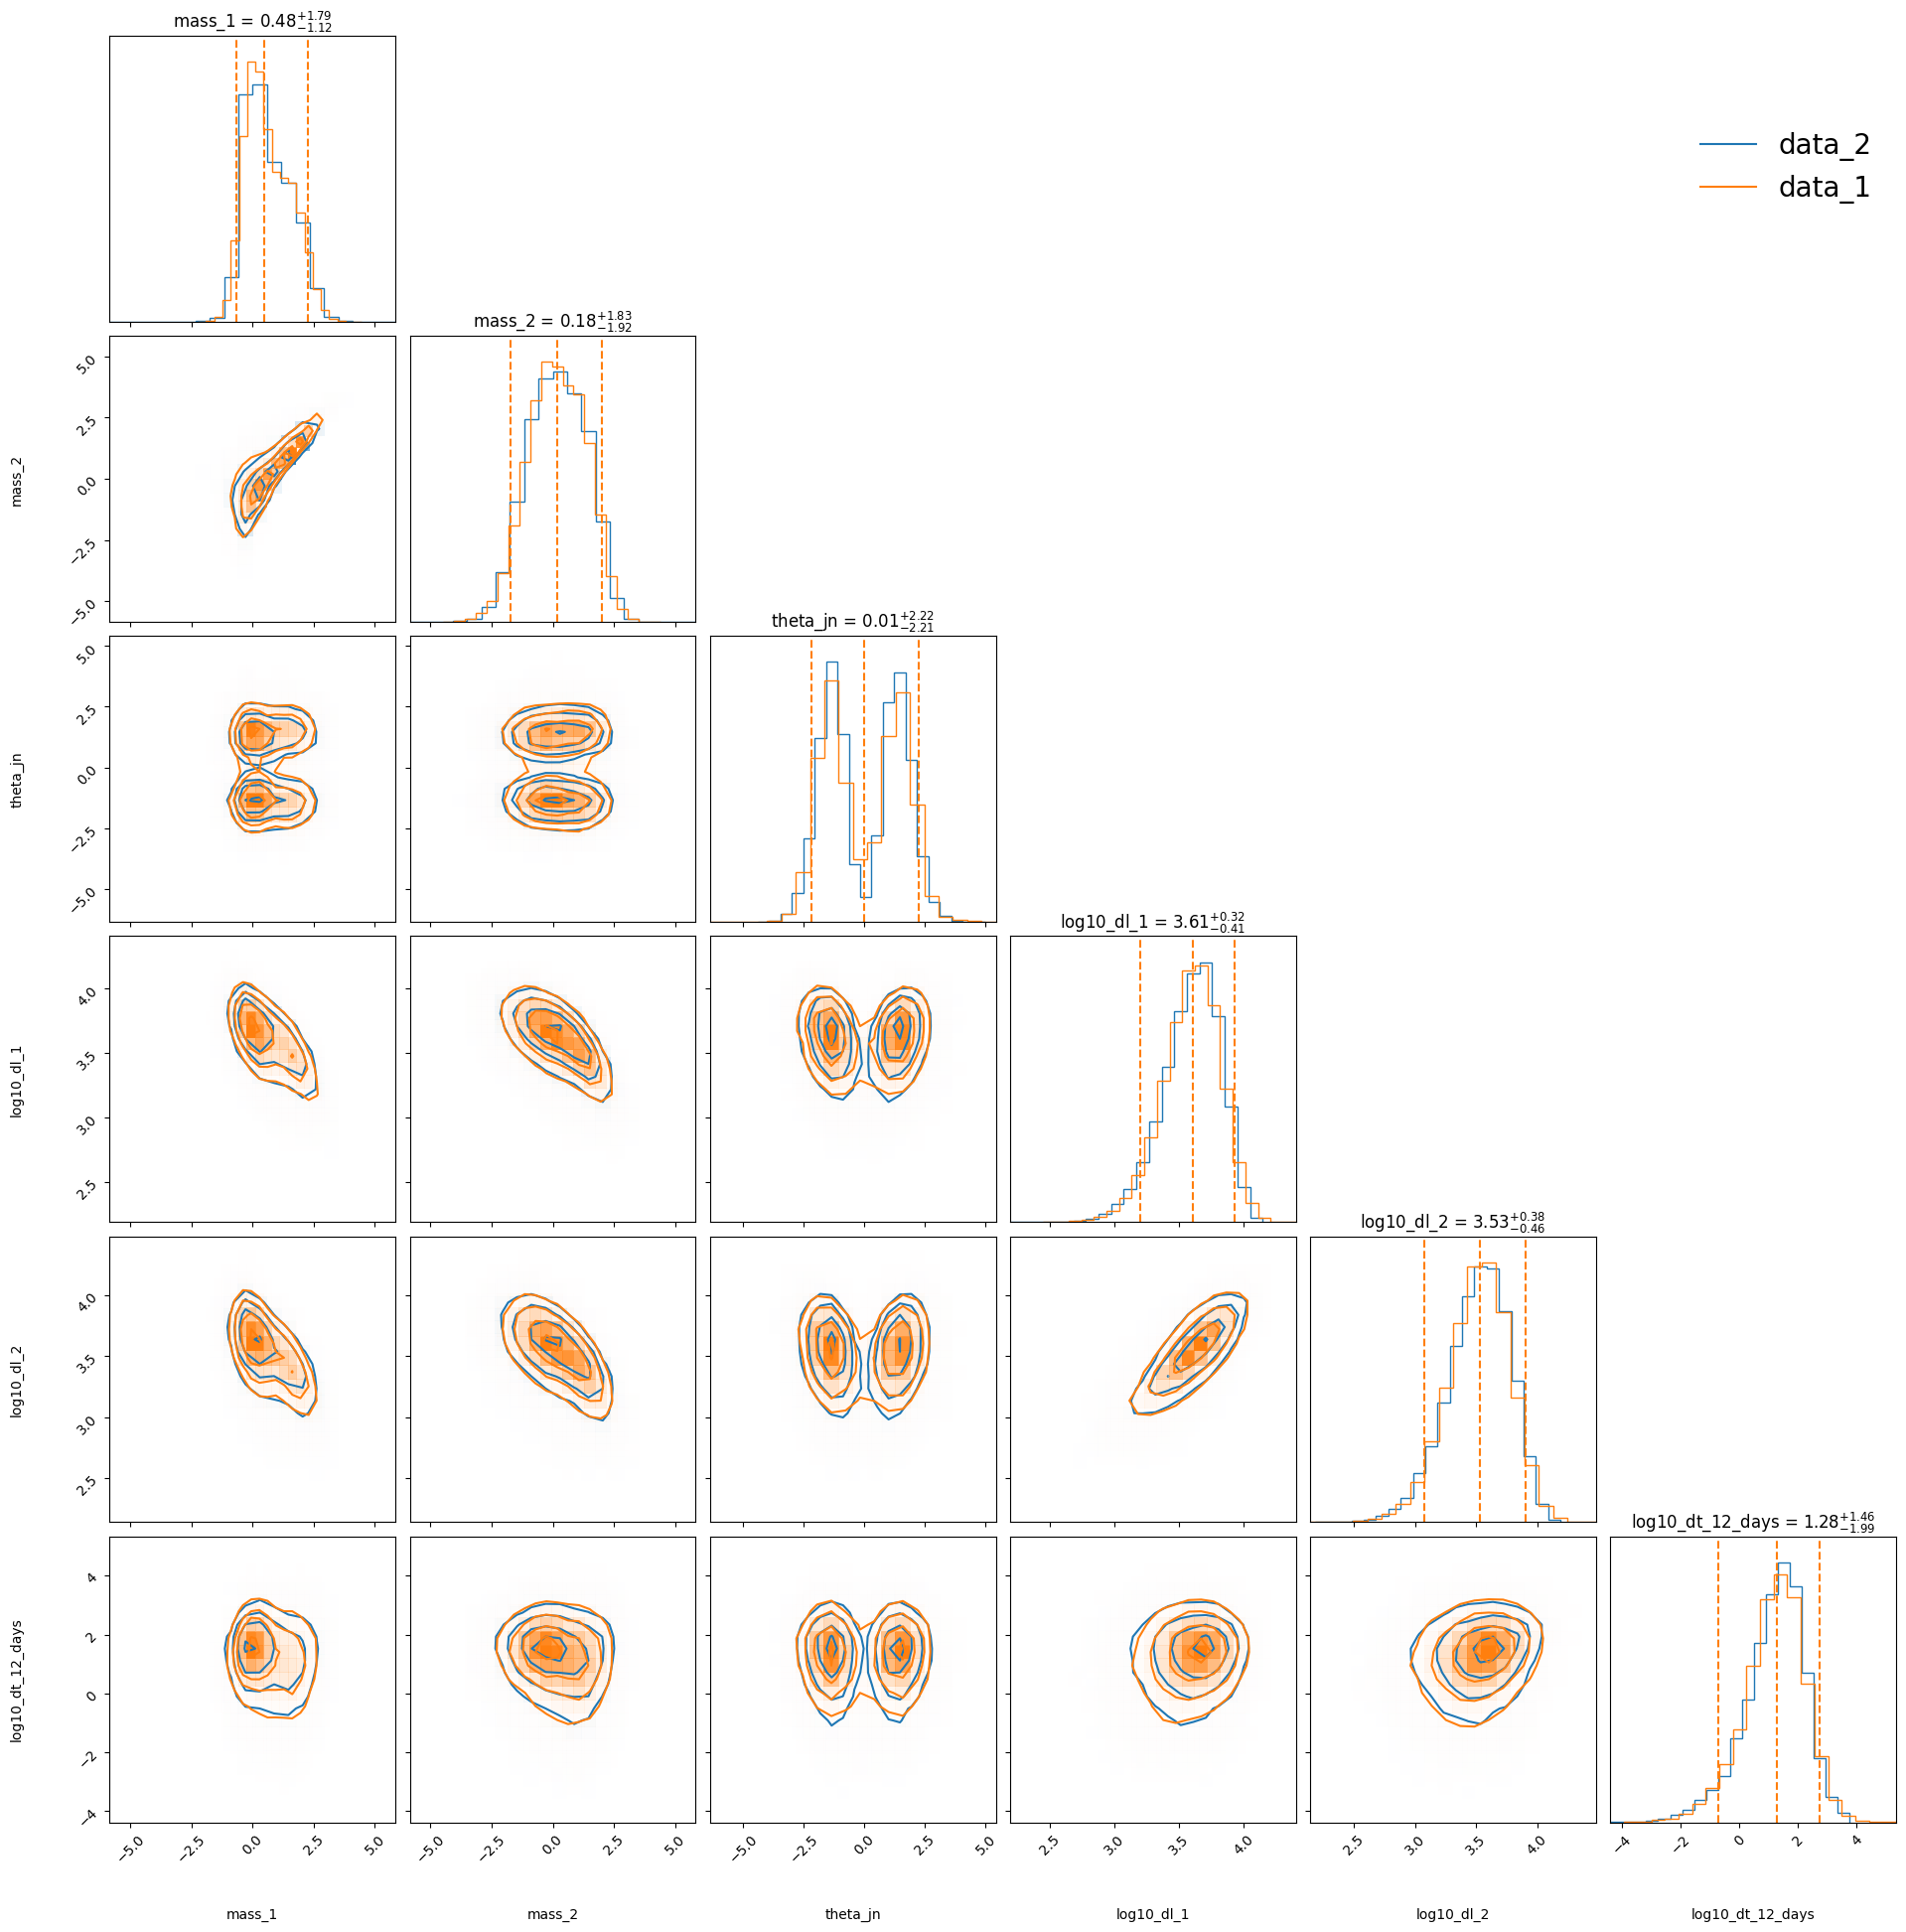

In [55]:
new_samples = dpgmm.sample(40000)[0]
# unscale data
new_samples = scaler.inverse_transform(new_samples)


new_samples_dict = dict(
    mass_1 = new_samples[:,0],
    mass_2 = new_samples[:,1],
    theta_jn = new_samples[:,2],
    log10_dl_1 = new_samples[:,3],
    log10_dl_2 = new_samples[:,4],
    log10_dt_12_days = new_samples[:,5],
)
train_data_dict = dict(
    mass_1 = train_data_[:,0],
    mass_2 = train_data_[:,1],
    theta_jn = train_data_[:,2],
    log10_dl_1 = train_data_[:,3],
    log10_dl_2 = train_data_[:,4],
    log10_dt_12_days = train_data_[:,5],
)

test1.plot(new_samples_dict, train_data_dict)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pobs.utils import save_json, load_json, data_check_astro_lensed_dpgmm, data_check_astro_lensed_sky_dpgmm, data_check_astro_unlensed_dpgmm, data_check_astro_unlensed_time_dpgmm 
from pobs.modelgenerator_dpgmm import ModelGenerator

data_dict = load_json('/Users/phurailatpamhemantakumar/phd/mypackages/pobs/pobs/data/n_unlensed_detectable_bbh_po_spin.json')
# data_dict = load_json('/Users/phurailatpamhemantakumar/phd/po-tutorial-2022/ler_data/n_unlensed_detectable_bbh_po_spin.json')
data_dict = data_check_astro_unlensed_time_dpgmm(data_dict, size=100000)

In [2]:
test = ModelGenerator(
    model_name='astro_unlensed_time', 
    create_new=True,
    n_components=20,
    weight_concentration_prior=1e-2,
    max_iter=1000,
    random_state=42,
    )

astro_unlensed is None
getting default astro_unlensed data_dict from pobs module


/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


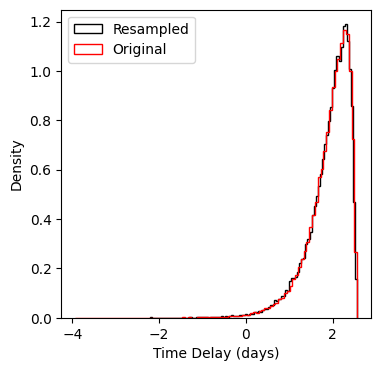

In [10]:
new_samples = test.resample(50000)

plt.figure(figsize=(4, 4))
plt.hist(new_samples['log10_dt_12_days'], bins=100, histtype='step', color='black', label='Resampled', density=True)
plt.hist(data_dict['log10_dt_12_days'], bins=100, histtype='step', color='red', label='Original', density=True)
plt.xlabel('Time Delay (days)')
plt.ylabel('Density')
plt.legend()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'hist'

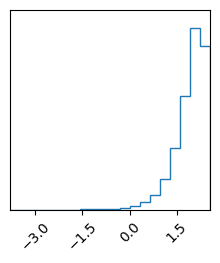

In [3]:
new_samples = test.resample(50000)
test.plot(new_samples, data_dict)

In [10]:
# from pobs.utils import save_min_max, load_json
# filename = test.meta_dict["min_max_path"]
# # min_max = save_min_max(filename, test.data_dict)
# # test.min_max = min_max
# min_max = load_json(filename)

In [9]:
# new_samples_x,_ = test.scaling(data_dict=test.data_dict, which_type="forward")
# test.plot(new_samples_x)

In [27]:
# new_samples,_ = test.scaling(data_dict=new_samples, which_type="backward")
# test.plot(new_samples)

In [3]:
data = test.model.sample(40000)[0]
new_samples = {}
j=0
for key in test.meta_dict['scaling_param'].keys():
    new_samples[key] = np.array(data[:,j])
    j+=1
new_samples, _ = test.scaling(data_list=data, which_type="backward")

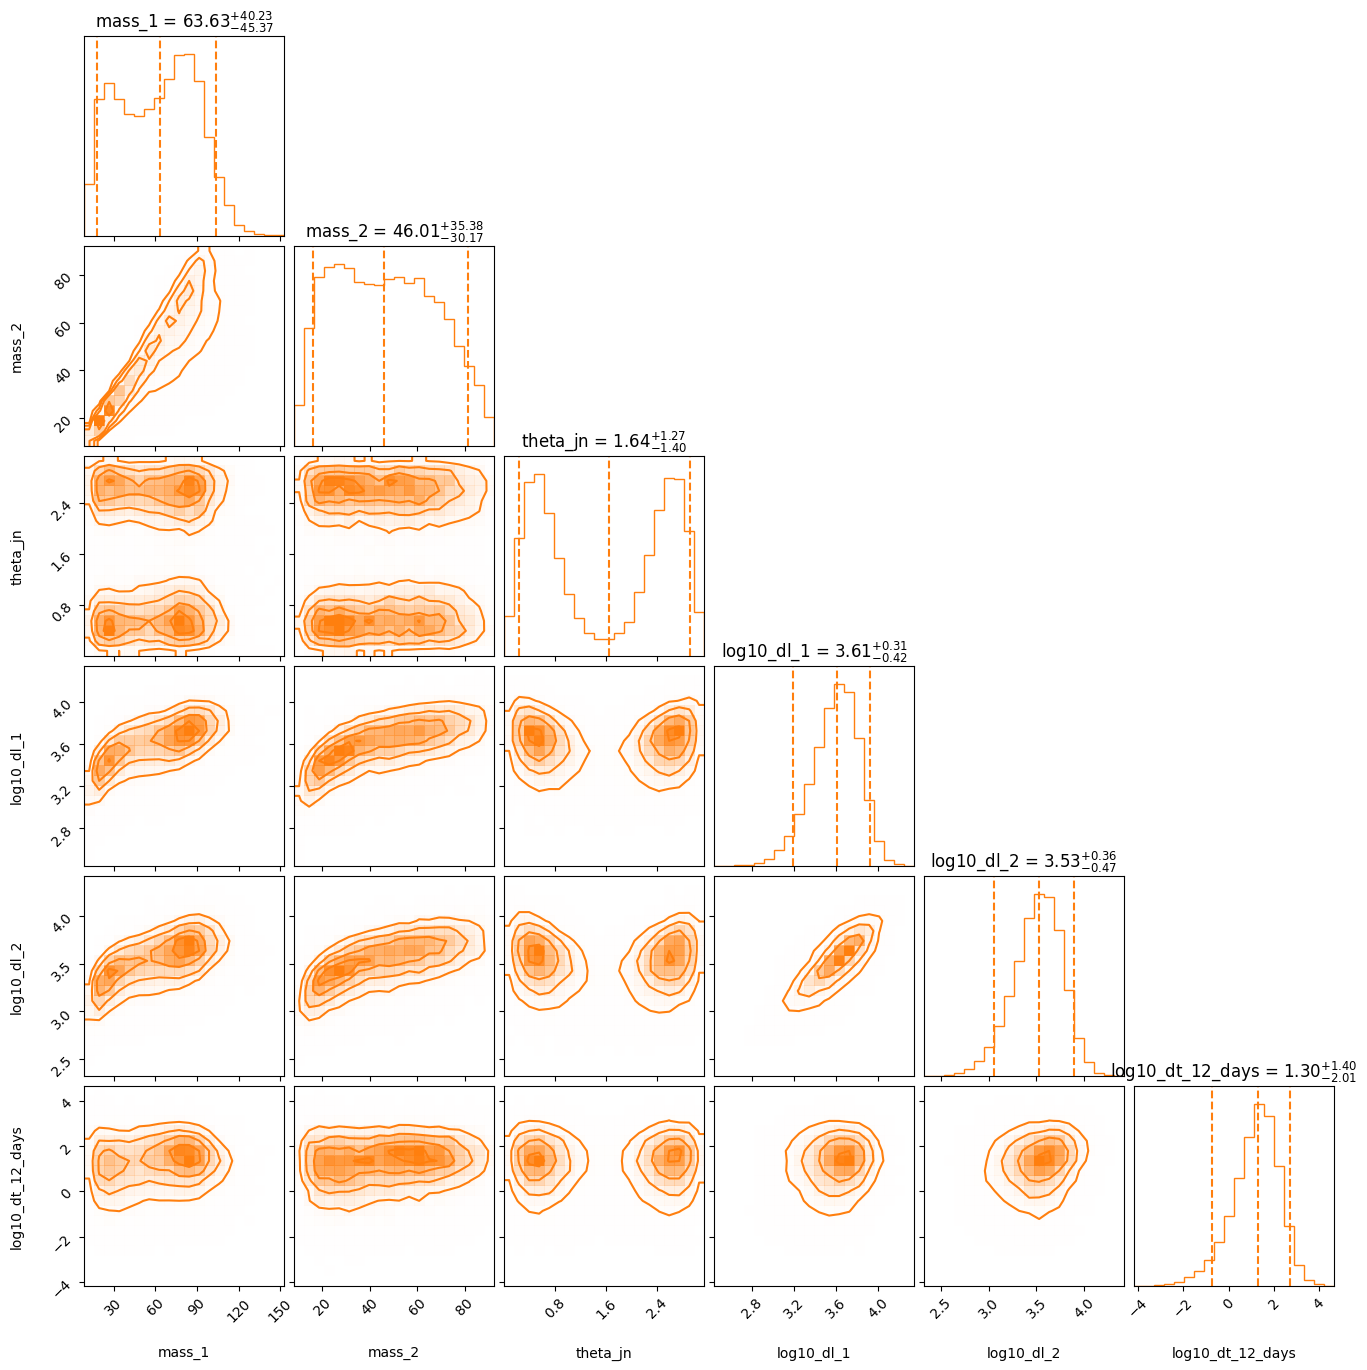

In [4]:
test.plot(new_samples)

In [1]:
from gwsnr import GWSNR

In [2]:
snr = GWSNR(waveform_approximant='TaylorF2', snr_type='inner_product')

psds not given. Choosing bilby's default psds

Chosen GWSNR initialization parameters:

npool:  4
snr type:  inner_product
waveform approximant:  TaylorF2
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['L1', 'H1', 'V1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/AdV_asd.txt')]


In [10]:
snr.compute_bilby_snr(gw_param_dict= {'mass_1':1.61, 'mass_2':1.18, 'a_1':0., 'a_2':0., 'tilt_1':0., 'tilt_2':0., 'phi_12':0., 'phi_jl':0., 'luminosity_distance':300.0, 'theta_jn':2.52, 'psi':3.293627, 'phase':0., 'geocent_time':1246527184.169434, 'ra':3.45, 'dec':-0.41,})

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.13s/it]


{'L1': array([7.61382377]),
 'H1': array([4.96269497]),
 'V1': array([4.56860101]),
 'optimal_snr_net': array([10.17205825])}